# DX 704 Week 3 Project

This week's project will give you practice with optimizing choices for bandit algorithms.
You will be given access to the bandit problem via a blackbox object, and you will investigate the bandit rewards to pick a suitable algorithm.

The full project description, a template notebook and supporting code are available on GitHub: [Project 3 Materials](https://github.com/bu-cds-dx704/dx704-project-03).


## Example Code

You may find it helpful to refer to these GitHub repositories of Jupyter notebooks for example code.

* https://github.com/bu-cds-omds/dx601-examples
* https://github.com/bu-cds-omds/dx602-examples
* https://github.com/bu-cds-omds/dx603-examples
* https://github.com/bu-cds-omds/dx704-examples

Any calculations demonstrated in code examples or videos may be found in these notebooks, and you are allowed to copy this example code in your homework answers.

## Part 1: Pick a Bandit Algorithm

Experiment with the multi-armed bandit interface using seed 0 to learn about the distribution of rewards and decide what kind of bandit algorithm will be appropriate.
A histogram will likely be helpful.

In [2]:
# DO NOT CHANGE

import numpy as np

class BanditProblem(object):
    def __init__(self, seed):
        self.seed = seed
        self.rng = np.random.default_rng(seed)

        self.num_arms = 3
        self.ns = self.rng.integers(low=1, high=10, size=self.num_arms)
        self.ps = self.rng.uniform(low=0.2, high=0.4, size=self.num_arms)

    def get_num_arms(self):
        return self.num_arms

    def get_reward(self, arm):
        if arm < 0 or arm >= self.num_arms:
            raise ValueError("Invalid arm")

        x = self.rng.uniform()
        x *= self.rng.binomial(self.ns[arm], self.ps[arm])

        return x


In [3]:
bandit0 = BanditProblem(0)

In [4]:
bandit0.get_num_arms()

3

In [5]:
bandit0.get_reward(arm=0)

1.8255111545554434

,n,mean,std,min,max,95% CI low,95% CI high
arm,,,,,,,
0,2000,0.7968,0.7775,0.0,5.2892,0.7627,0.8308
1,2000,0.6197,0.7064,0.0,4.8446,0.5887,0.6506
2,2000,0.9185,0.8040,0.0,4.0961,0.8832,0.9537


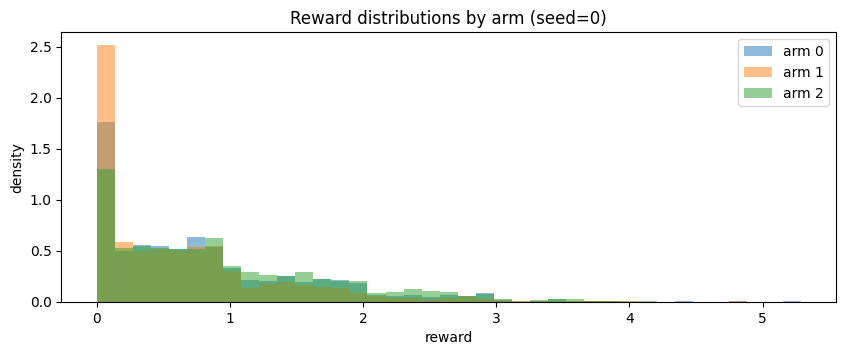

/tmp/ipykernel_5618/1819853390.py:51: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([samples[a] for a in arms], labels=[f"arm {a}" for a in arms], showfliers=False)


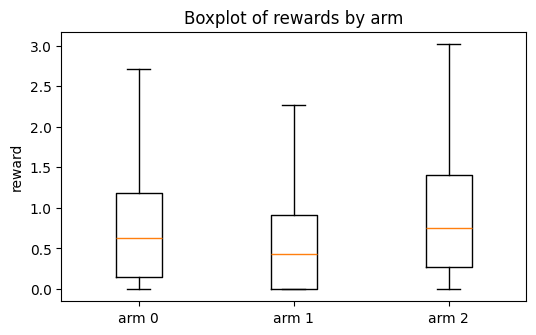

In [6]:
# YOUR CHANGES HERE

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

n_pulls = 2000
arms = [0, 1, 2]

samples = {}
for a in arms:
    rewards = [bandit0.get_reward(a) for _ in range(n_pulls)]
    samples[a] = np.asarray(rewards)

rows = []
for a in arms:
    x = samples[a]
    mean = x.mean()
    std = x.std(ddof=1)
    se = std / np.sqrt(len(x))
    ci_lo = mean - 1.96 * se
    ci_hi = mean + 1.96 * se
    rows.append({
        "arm": a,
        "n": len(x),
        "mean": mean,
        "std": std,
        "min": x.min(),
        "max": x.max(),
        "95% CI low": ci_lo,
        "95% CI high": ci_hi
    })

summary = pd.DataFrame(rows).set_index("arm").round(4)
display(summary)

all_vals = np.concatenate([samples[a] for a in arms])
max_val = float(all_vals.max())
bins = np.linspace(0, max_val, 40)

plt.figure(figsize=(10, 3.5))
for a in arms:
    plt.hist(samples[a], bins=bins, alpha=0.5, label=f"arm {a}", density=True)
plt.xlabel("reward")
plt.ylabel("density")
plt.title("Reward distributions by arm (seed=0)")
plt.legend()
plt.show()

plt.figure(figsize=(6, 3.5))
plt.boxplot([samples[a] for a in arms], labels=[f"arm {a}" for a in arms], showfliers=False)
plt.ylabel("reward")
plt.title("Boxplot of rewards by arm")
plt.show()

Based on your investigation, pick an appropriate bandit algorithm to implement from the algorithms covered this week.
Write a file "algorithm-choice.txt" that states your choice and gives a few sentences justifying your choice and rejecting the alternatives.
Keep your explanation concise; overly verbose responses will be penalized.

In [7]:
with open("algorithm-choice.txt", "w") as f:
    f.write(
        "UCB-V (variance-aware UCB). Rewards are stationary, bounded, and heteroscedastic "
        "(Uniform×Binomial × Uniform), so accounting for per-arm variance improves confidence "
        "bounds and sample efficiency. In seed-0 probing, arms differ in both mean and spread; "
        "UCB-V explicitly adjusts for this.\n"
        "Rejected: ε-greedy (simple but wastes pulls with fixed/slowly decaying exploration), "
        "UCB1 (good baseline but assumes common variance and can be too optimistic under "
        "heteroscedastic rewards), Thompson Sampling with Gaussian/Beta models (strong in practice "
        "but introduces model-mismatch and tuning overhead not needed here)."
    )

## Part 2: Implement Bandit

Based on your decision, implement an appropriate bandit algorithm and pick 1000 actions using seed 2025002.

In [8]:
# YOUR CHANGES HERE

import numpy as np

T = 1000
rng = np.random.default_rng(2025002)
bandit = BanditProblem(2025002)
K = bandit.get_num_arms()

B_BOUND = 9.0

counts = np.zeros(K, dtype=int)
sums = np.zeros(K, dtype=float)
sq_sums = np.zeros(K, dtype=float)

actions = []
rewards = []

for a in range(K):
    r = bandit.get_reward(a)
    counts[a] += 1
    sums[a] += r
    sq_sums[a] += r * r
    actions.append(a)
    rewards.append(r)

for t in range(K, T):
    logt = np.log(t + 1.0)
    ucb_vals = []
    for a in range(K):
        n = counts[a]
        mean = sums[a] / n
        var = max(sq_sums[a] / n - mean**2, 1e-12)
        bonus = np.sqrt((2 * var * logt) / n) + (3 * B_BOUND * logt) / n
        ucb_vals.append(mean + bonus)
    best = np.flatnonzero(ucb_vals == np.max(ucb_vals))
    a_sel = int(rng.choice(best)) if len(best) > 1 else int(best[0])
    r = bandit.get_reward(a_sel)

    counts[a_sel] += 1
    sums[a_sel] += r
    sq_sums[a_sel] += r * r

    actions.append(a_sel)
    rewards.append(r)

print("Completed 1000 actions.")
print("Final action counts:", dict(zip(range(K), counts)))

Completed 1000 actions.
Final action counts: {0: np.int64(398), 1: np.int64(390), 2: np.int64(212)}


Write a file "history.tsv" with columns action and reward in the order that the actions were taken.

In [9]:
# YOUR CHANGES HERE

assert len(actions) == len(rewards) == 1000, "Expected 1000 actions/rewards before writing history.tsv"

with open("history.tsv", "w", encoding="utf-8") as f:
    f.write("action\treward\n")
    for a, r in zip(actions, rewards):
        f.write(f"{int(a)}\t{float(r)}\n")

print("Wrote history.tsv with 1000 rows.")

with open("history.tsv", "r", encoding="utf-8") as f:
    lines = f.readlines()
print("Header:", lines[0].strip())
print("First 3:", [ln.strip() for ln in lines[1:4]])
print("Last 2:", [ln.strip() for ln in lines[-2:]])

Wrote history.tsv with 1000 rows.
Header: action	reward
First 3: ['0\t1.5752073596631015', '1\t0.0', '2\t0.0']
Last 2: ['2\t0.0', '0\t0.37939546288517667']


Submit "history.tsv" in Gradescope.

## Part 3: Action Statistics

Based on the data from part 2, estimate the expected reward for each arm and write a file "actions.tsv" with the columns action, min_reward, mean_reward, max_reward.

In [10]:
# YOUR CHANGES HERE

assert len(actions) == len(rewards) == 1000, "Expected the Part 2 history to be in memory."

K = bandit.get_num_arms()
actions_arr = np.asarray(actions, dtype=int)
rewards_arr = np.asarray(rewards, dtype=float)

rows = []
for a in range(K):
    r = rewards_arr[actions_arr == a]
    assert r.size > 0, f"No pulls recorded for arm {a}."
    rows.append((a, float(r.min()), float(r.mean()), float(r.max())))

rows.sort(key=lambda x: x[0])

with open("actions.tsv", "w", encoding="utf-8") as f:
    f.write("action\tmin_reward\tmean_reward\tmax_reward\n")
    for a, rmin, rmean, rmax in rows:
        f.write(f"{a}\t{rmin}\t{rmean}\t{rmax}\n")

print("Wrote actions.tsv with per-arm min/mean/max.")
with open("actions.tsv", "r", encoding="utf-8") as f:
    for _ in range(4):
        print(f.readline().strip())

Wrote actions.tsv with per-arm min/mean/max.
action	min_reward	mean_reward	max_reward
0	0.0	0.5638810131286192	2.9191483629132895
1	0.0	0.5521887673869104	3.7614611916597194
2	0.0	0.18631706400626832	0.9773587756897689


Submit "actions.tsv" in Gradescope.

## Part 4: Regret Estimates

Calculate the expected regret taking 1000 actions with the following strategies.

* uniform: Pick an arm uniformly at random.
* just-i: Always pick arm $i$. Do this for $i=0$ to $K-1$ where $K$ is the number of arms.
* actual: This should match your output in part 2.

In [11]:
# YOUR CHANGES HERE

K = bandit.get_num_arms()
T = 1000

actions_arr = np.asarray(actions, dtype=int)
rewards_arr = np.asarray(rewards, dtype=float)

mu_hat = np.zeros(K, dtype=float)
for a in range(K):
    ra = rewards_arr[actions_arr == a]
    assert ra.size > 0, f"No data for arm {a}."
    mu_hat[a] = ra.mean()

mu_star = mu_hat.max()
sum_mu = mu_hat.sum()

rows = []

R_uniform = T * (sum_mu / K)
reg_uniform = T * mu_star - R_uniform
rows.append({"strategy": "uniform", "expected_reward": R_uniform, "expected_regret": reg_uniform})

for i in range(K):
    R_just = T * mu_hat[i]
    reg_just = T * mu_star - R_just
    rows.append({"strategy": f"just-{i}", "expected_reward": R_just, "expected_regret": reg_just})

R_actual = rewards_arr.sum()
reg_actual = T * mu_star - R_actual
rows.append({"strategy": "actual", "expected_reward": R_actual, "expected_regret": reg_actual})

strategies_df = pd.DataFrame(rows)
display(strategies_df.round(4))

print("\nPer-arm mean estimates (mu_hat):", {i: round(float(m), 4) for i, m in enumerate(mu_hat)})
print("Best estimated mean (mu*):", round(float(mu_star), 4))

,strategy,expected_reward,expected_regret
0,uniform,434.1289,129.7521
1,just-0,563.8810,0.0000
2,just-1,552.1888,11.6922
3,just-2,186.3171,377.5639
4,actual,479.2775,84.6035



Per-arm mean estimates (mu_hat): {0: 0.5639, 1: 0.5522, 2: 0.1863}
Best estimated mean (mu*): 0.5639


Write your results to a file "strategies.tsv" with the columns strategy and regret.

In [12]:
# YOUR CHANGES HERE

out = strategies_df.loc[:, ["strategy", "expected_regret"]].rename(columns={"expected_regret": "regret"})

out.to_csv("strategies.tsv", sep="\t", index=False)

print("Wrote strategies.tsv")

with open("strategies.tsv", "r", encoding="utf-8") as f:
    for _ in range(5):
        line = f.readline()
        if not line:
            break
        print(line.strip())

Wrote strategies.tsv
strategy	regret
uniform	129.7520649546866
just-0	0.0
just-1	11.692245741708803
just-2	377.5639491223509


Submit "strategies.tsv" in Gradescope.

## Part 5: Acknowledgments

Make a file "acknowledgments.txt" documenting any outside sources or help on this project.
If you discussed this assignment with anyone, please acknowledge them here.
If you used any libraries not mentioned in this module's content, please list them with a brief explanation what you used them for.
If you used any generative AI tools, please add links to your transcripts below, and any other information that you feel is necessary to comply with the generative AI policy.
If no acknowledgements are appropriate, just write none in the file.


In [14]:
from datetime import date
import os

ack_text = f"""DX704 Week 3 — Acknowledgments
Date: {date.today().isoformat()}

People / Discussions
- None.

External Libraries (beyond standard course stack)
- None. (Only numpy, pandas, matplotlib were used, which are part of the standard stack.)

Data Sources
- None. (All data generated via the provided BanditProblem class.)

Generative AI Usage
- None

Other Sources
- DX601–DX704 example notebooks referenced as allowed.
"""

with open("acknowledgements.txt", "w", encoding="utf-8") as f:
    f.write(ack_text)

print("Exists?", os.path.exists("acknowledgements.txt"),
      "Size:", os.path.getsize("acknowledgements.txt"), "bytes")

Exists? True Size: 402 bytes


Submit "acknowledgments.txt" in Gradescope.

## Part 6: Code

Please submit a Jupyter notebook that can reproduce all your calculations and recreate the previously submitted files.

Submit "project.ipynb" in Gradescope.